# ART Adversarial Patch attack

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import random
import numpy as np
import tensorflow as tf
sess = tf.InteractiveSession()
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label
import warnings
warnings.filterwarnings('ignore')

from art.classifiers.tensorflow import TFClassifier
from art.attacks.adversarial_patch import AdversarialPatch

Using TensorFlow backend.


# Settings

In [2]:
target_image_name = 'toaster.jpg'
patch_shape = (224, 224, 3)
image_shape = (224, 224, 3)
batch_size = 3
scale_min = 0.3
scale_max = 1.0
rotation_max = 22.5
learning_rate = 200000.0
number_of_steps = 1000

# Model definition

In [3]:
y_one_hot = np.zeros(1000)
y_one_hot[name_to_label('toaster')] = 1.0
target_ys = np.tile(y_one_hot, (batch_size, 1))

In [4]:
_image_input = tf.keras.Input(shape=image_shape)
_target_ys = tf.placeholder(tf.float32, shape=(None, 1000))
model = tf.keras.applications.resnet50.ResNet50(input_tensor=_image_input, weights='imagenet')
_logits = model.outputs[0].op.inputs[0]
target_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=_target_ys, logits=_logits))

tfc = TFClassifier(clip_values=(0, 1), input_ph=_image_input, output_ph=_target_ys, logits=_logits, sess=sess, loss=target_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# Imagenet training images

In [5]:
images_list = list()
target_image = None

for image_path in imagenet_stubs.get_image_paths():
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    im = preprocess_input(im)
    
    if image_path.endswith(target_image_name):
        target_image = im
    else:
        images_list.append(im)

images = random.sample(images_list, batch_size)
images = np.concatenate(images, axis=0)

# Adversarial patch generation

In [7]:
ap = AdversarialPatch(classifier=tfc)

attack_params = {"target_ys": target_ys, "rotation_max": rotation_max, "scale_min": scale_min, "scale_max": scale_max,
                 "learning_rate": learning_rate, "number_of_steps": number_of_steps, "patch_shape": patch_shape, 
                 "batch_size": batch_size, "clip_patch": [(-103.939, 255.0 - 103.939), (-116.779, 255.0 - 116.779), (-123.680, 255.0 - 123.680)]}

patch, patch_mask = ap.generate(x=images, **attack_params)

Training Step: 1
Training Step: 100
Training Step: 200
Training Step: 300
Training Step: 400
Training Step: 500
Training Step: 600
Training Step: 700
Training Step: 800
Training Step: 900
Training Step: 1000


In [8]:
def from_keras(x):
    x = np.copy(x)
    x[:, :, 2] += 123.68
    x[:, :, 1] += 116.779
    x[:, :, 0] += 103.939
    return x[:, :, [2, 1, 0]].astype(np.uint8)

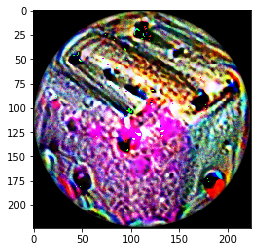

In [9]:
plt.imshow((from_keras(patch) * patch_mask).astype(np.uint))

# Evaluation

In [10]:
patched_images = ap.apply_patch(images, scale=0.5)

In [11]:
def predict_model(model, image):
    plt.imshow((from_keras(image)).astype(np.uint))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    
    prediction = model.predict(image)
    
    top = 3
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)

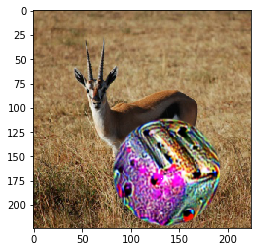

Predictions:
toaster     1.00
piggy_bank  0.00
leaf_beetle 0.00


In [12]:
predict_model(model, patched_images[0, :, :, :])

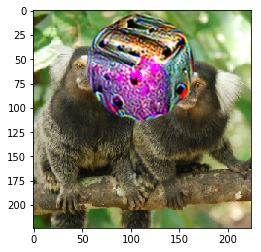

Predictions:
toaster    1.00
piggy_bank 0.00
printer    0.00


In [13]:
predict_model(model, patched_images[1, :, :, :])

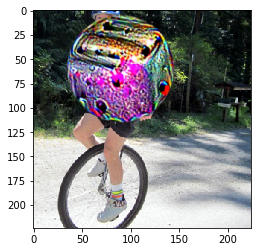

Predictions:
toaster       1.00
mailbox       0.00
parking_meter 0.00


In [14]:
predict_model(model, patched_images[2, :, :, :])